In [30]:
import pandas as pd
import numpy as np
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import seaborn as sns

In [184]:
data = pd.DataFrame(web.DataReader("^VIX", data_source="yahoo", start= "2019-9-1", end = "2019-12-31")["Adj Close"])

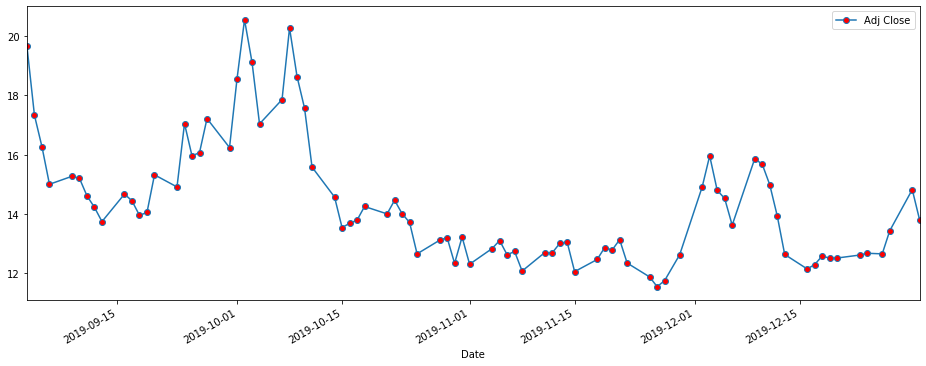

In [185]:
data.plot(figsize = (16,6), marker = "o", mfc = "r");

## Spliting
- we will take 30days of the data as our training set..

In [186]:
test_percent = 0.20
sizz = np.round(len(data) * test_percent)
sizz

17.0

In [187]:
test_index = int(len(data) - sizz)

In [188]:
test_index

67

In [189]:
len(data)

84

## Training

In [190]:
train = data.iloc[:test_index]

In [191]:
test = data.iloc[test_index:]

In [192]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67 entries, 2019-09-03 to 2019-12-05
Data columns (total 1 columns):
Adj Close    67 non-null float64
dtypes: float64(1)
memory usage: 1.0 KB


In [193]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17 entries, 2019-12-06 to 2019-12-31
Data columns (total 1 columns):
Adj Close    17 non-null float64
dtypes: float64(1)
memory usage: 272.0 bytes


### Scaling the data

In [194]:
from sklearn.preprocessing import MinMaxScaler

In [195]:
scalar = MinMaxScaler()

In [196]:
train_scaled = scalar.fit_transform(train)

In [202]:
train_scaled.shape

(67, 1)

In [197]:
test_scaled = scalar.transform(test)

In [203]:
test_scaled.shape

(17, 1)

## Plots

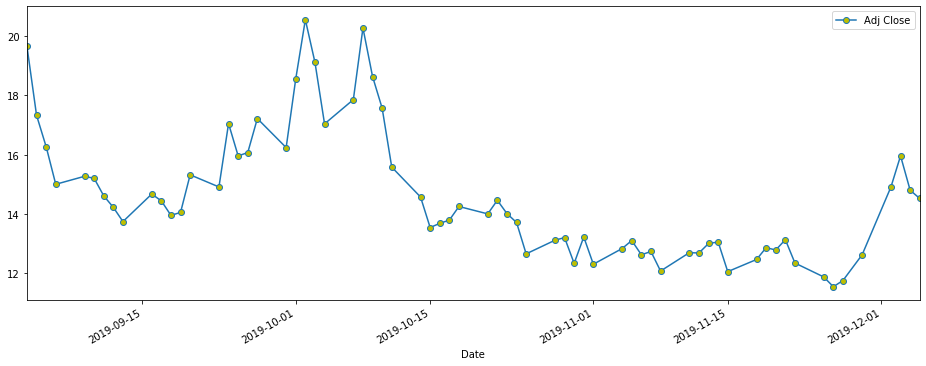

In [204]:
train.plot(figsize = (16,6), marker = "o", mfc = "y")

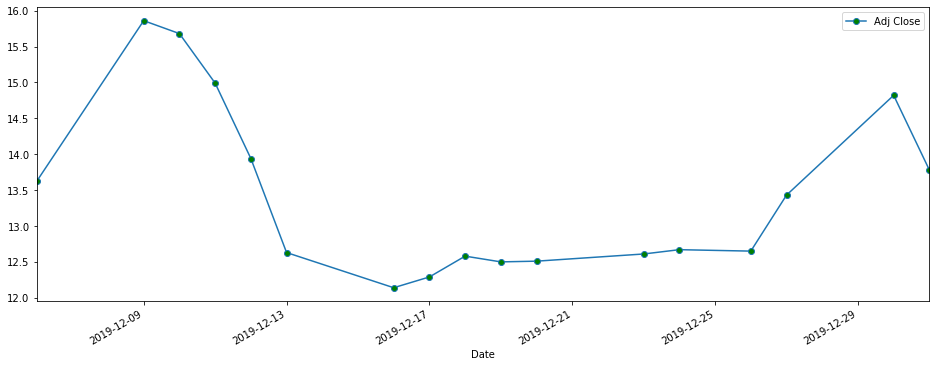

In [205]:
test.plot(figsize = (16,6), marker = "o", mfc = "g")

### Batches with time series Generator

In [206]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [207]:
length = 15
generator = TimeseriesGenerator(train_scaled,train_scaled, batch_size=1,length= length)

## Reviewing Generator
- Generator is proving to be structured correctly for the y value at position 30 is accurate

In [208]:
X,y = generator[0]

In [209]:
X

array([[[0.90022177],
        [0.6419069 ],
        [0.52439033],
        [0.38359204],
        [0.41352558],
        [0.40576497],
        [0.34035475],
        [0.29711757],
        [0.24390243],
        [0.34700668],
        [0.32150774],
        [0.26718403],
        [0.27827055],
        [0.41906873],
        [0.3736142 ]]])

In [210]:
y

array([[0.6108647]])

In [212]:
train_scaled[10:16]

array([[0.32150774],
       [0.26718403],
       [0.27827055],
       [0.41906873],
       [0.3736142 ],
       [0.6108647 ]])

### Model Creation

In [213]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN, LSTM

In [214]:
n_features = 1

In [215]:
model = Sequential()
model.add(LSTM(units = 50, activation = "relu", input_shape = (length, n_features)))
model.add(Dense(units = 1))
model.compile(optimization = "adam", loss = "mse")

In [216]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


### Earlly Stopping:
- Since RNN takes time to train we can set our Epoch value and let tensorFLow deside to stop training when the loss value is low enough and break when the model begins to overtrain

In [217]:
from tensorflow.keras.callbacks import EarlyStopping

In [218]:
early = EarlyStopping(monitor= "val_loss", patience=2)

### Vaidation generator
-- Since we are fitting to a generator our validation data must come from a generator and out validation data will come from our scaled test set

In [219]:
validation_g = TimeseriesGenerator(test_scaled,test_scaled,length= length,batch_size=1)

## fitting model

In [220]:
model.fit_generator(generator, validation_data=validation_g, epochs=20, callbacks=[early])

Epoch 1/20
52/52 [==============================] - 37s 706ms/step - loss: 0.0819 - val_loss: 0.0183
Epoch 2/20
52/52 [==============================] - 36s 693ms/step - loss: 0.0442 - val_loss: 0.0159
Epoch 3/20
52/52 [==============================] - 36s 688ms/step - loss: 0.0386 - val_loss: 0.0287
Epoch 4/20
52/52 [==============================] - 36s 695ms/step - loss: 0.0384 - val_loss: 0.0169


## model performance 

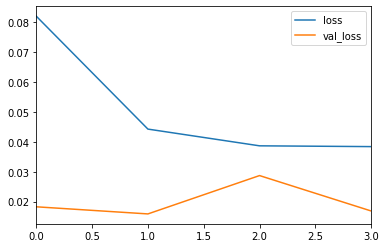

In [221]:
pd.DataFrame(model.history.history).plot()

## Test predictions
- Using our model to make predictions on the Testing data

In [222]:
test_predictions = []
first_batch = train_scaled[-length:]
current_batch = first_batch.reshape((1,length,n_features))

for i in range(len(test)):
    current_prediciton = model.predict(current_batch)[0]
    test_predictions.append(current_prediciton)
    current_batch = np.append(current_batch[:,1:,:], [[current_prediciton]], axis = 1)
    

### inverse Scaling
- WE have to remember out model was trained on scaled data so we need to inverse this process for the true value
- we will then need to match these predicitons up with our original test data

In [178]:
true_predictions = scalar.inverse_transform(test_predictions)

In [179]:
test["predicitons"] = true_predictions

/Users/berkatbhatti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [180]:
test

,Adj Close,predicitons
Date,,
2020-03-10,40.450001,26.345742
2020-03-11,48.220001,26.291161
2020-03-12,65.019997,26.221076
2020-03-13,57.240002,26.063062
2020-03-16,90.139999,25.820681
2020-03-17,87.230003,25.510536
2020-03-18,110.629997,25.145854
2020-03-19,94.089996,24.738097
2020-03-20,91.110001,24.297278


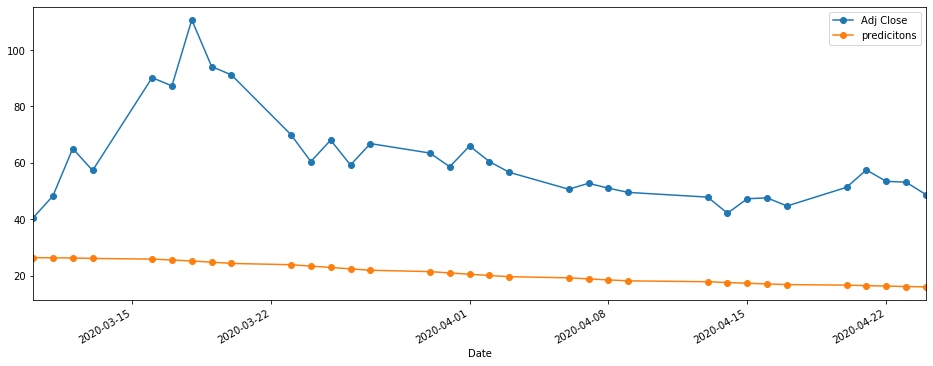

In [181]:
test.plot(figsize = (16,6), marker = "o")